### Βαθιά μάθηση: συνελικτικά δίκτυα

Για αυτό το μέρος της εργασίας αποφασίσαμε να δουλέψουμε με ένα νευρωνικό δίκτυο "from scratch" γιατί πιστεύαμε ότι θα ήταν πιο ενδιαφέρον από το transfer learning. Δυστυχώς, δεν καταφέραμε να αναπτύξουμε ένα δίκτυο με μεγάλη ακρίβεια. Το τελικό δίκτυο που θα παρουσιαστεί αποτελείται από 6 εκατομμύρια παραμέτρους αλλά πετυχαίνει ακρίβεια μόλις 0.48 μετά από 300(μπορεί και ελαφρώς καλύτερα με λίγη παραπάνω εκπαίδευση αλλά δεν αλλάζει κάτι στη σύγκριση αυτό). Στο παρόν notebook φαίνονται συγκρίσεις μεταξύ διαφορετικών αριθμών κλάσεων και διαφορετικών batch sizes. Το δίκτυο έγινε optimize με βάση τις 80 κλάσεις οπότε στις 20, αν και πετυχαίνει αρκετά μεγαλύτερο σκορ, πέφτει και σε σημαντικό overfitting. Όσο αυξάνουμε τις κλάσεις, το δίκτυο μαθαίνει πιο αργά και το validation score πλησιάζει αυτό του testing. Δηλαδή, πρακτικά, το νευρωνικό δεν προλαβαίνει να κάνει overfitting. Το δεύτερο αντικείμενο που παρουσιάζεται είναι η επίδραση της συστάδας. Εδώ η κατάσταση είναι πολύ απλή, καθώς όσο μικρότερη η συστάδα τόσο λιγότερα μαθαίνει.

Από τις τεχνικές του notebook της εκφώνησης έγινε χρήση του dropout. Χωρίς αυτό το CNN μας μαθαίνει σχεδόν αποκλειστικά το training set χωρίς δυνατότητα γενίκευσης. Δοκιμάστηκαν ακόμη κάποιες μέθοδοι data augmentation(κυρίως περιστροφή και zoom) χωρίς σημαντική βελτίωση των αποτελεσμάτων. Ακόμη, πλην του αλγόριθμου SGD με ροπή δοκιμάστηκε και ο ADAM ως optimizer αλλά με σαφώς χειρότερα αποτελέσματα. Τέλος, δοκιμάσαμε τρεις διαφορετικούς ρυθμούς μάθησης: 0.001, 0.01 και 0.1 Ο πρώτος ήταν πολύ αργός ενώ ο τρίτος πολύ θορυβώδης, εξ ου και καταλήξαμε στο δεύτερο σαν μέση λύση.

Τα παρόν notebook εκτελέσθηκε στο Kaggle.

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#@title
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

# REPLACE WITH YOUR C NUMBER
team_seed = 176

#@title
# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, test_ds, evaluation_steps):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, test_ds, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, test_ds, evaluation_steps)

In [5]:
def init_scratch_model(summary):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.4))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.4))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.4))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.4))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.4))
    model.add(layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((1, 1)))
    model.add(layers.Dropout(.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='softmax'))  
  
    model.compile(optimizer=tf.optimizers.SGD(lr=0.01, momentum=0.9),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])
    if summary: model.summary()
    return model

In [7]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# steps_per_epoch and validation_steps for training and validation:
# https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(train_ds, val_ds, model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                      validation_data=validation_ds, validation_steps=validation_steps)
  return(history)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

40/40 [==============================] - 1s 25ms/step - loss: 1.4363 - accuracy: 0.5537 - val_loss: 1.5647 - val_accuracy: 0.5191
Epoch 92/300
40/40 [==============================] - 1s 26ms/step - loss: 1.4589 - accuracy: 0.5377 - val_loss: 1.5373 - val_accuracy: 0.5459
Epoch 93/300
40/40 [==============================] - 1s 23ms/step - loss: 1.4365 - accuracy: 0.5540 - val_loss: 1.5382 - val_accuracy: 0.5268
Epoch 94/300
40/40 [==============================] - 1s 25ms/step - loss: 1.4246 - accuracy: 0.5536 - val_loss: 1.5342 - val_accuracy: 0.5377
Epoch 95/300
40/40 [==============================] - 1s 23ms/step - loss: 1.4167 - accuracy: 0.5524 - val_loss: 1.5061 - val_accuracy: 0.5471
Epoch 96/300
40/40 [==============================] - 1s 23ms/step - loss: 1.3833 - accuracy: 0.5636 - val_loss: 1.5690 - val_accuracy: 0.5191
Epoch 97/300
40/40 [==============================] - 1s 23ms/step - loss: 1.3821 - accuracy: 0.5646 - val_loss: 1.5138 - val_accuracy: 0.5273
Epoch 98/300

40/40 [==============================] - 1s 26ms/step - loss: 0.9623 - accuracy: 0.6863 - val_loss: 1.3522 - val_accuracy: 0.6053
Epoch 149/300
40/40 [==============================] - 1s 25ms/step - loss: 0.9322 - accuracy: 0.7029 - val_loss: 1.3711 - val_accuracy: 0.6033
Epoch 150/300
40/40 [==============================] - 1s 24ms/step - loss: 0.9508 - accuracy: 0.7023 - val_loss: 1.3591 - val_accuracy: 0.5986
Epoch 151/300
40/40 [==============================] - 1s 23ms/step - loss: 0.9470 - accuracy: 0.6913 - val_loss: 1.2739 - val_accuracy: 0.6180
Epoch 152/300
40/40 [==============================] - 1s 23ms/step - loss: 0.8985 - accuracy: 0.7075 - val_loss: 1.3172 - val_accuracy: 0.5982
Epoch 153/300
40/40 [==============================] - 1s 23ms/step - loss: 0.9889 - accuracy: 0.6834 - val_loss: 1.3396 - val_accuracy: 0.6068
Epoch 154/300
40/40 [==============================] - 1s 23ms/step - loss: 0.9658 - accuracy: 0.6847 - val_loss: 1.3089 - val_accuracy: 0.6047
Epoch 

Epoch 205/300
40/40 [==============================] - 1s 23ms/step - loss: 0.6494 - accuracy: 0.7873 - val_loss: 1.2716 - val_accuracy: 0.6357
Epoch 206/300
40/40 [==============================] - 1s 27ms/step - loss: 0.6592 - accuracy: 0.7841 - val_loss: 1.3304 - val_accuracy: 0.6256
Epoch 207/300
40/40 [==============================] - 1s 23ms/step - loss: 0.6359 - accuracy: 0.7977 - val_loss: 1.3648 - val_accuracy: 0.6328
Epoch 208/300
40/40 [==============================] - 1s 24ms/step - loss: 0.6436 - accuracy: 0.7839 - val_loss: 1.3041 - val_accuracy: 0.6406
Epoch 209/300
40/40 [==============================] - 1s 23ms/step - loss: 0.5857 - accuracy: 0.8072 - val_loss: 1.3725 - val_accuracy: 0.6260
Epoch 210/300
40/40 [==============================] - 1s 23ms/step - loss: 0.6230 - accuracy: 0.8007 - val_loss: 1.3694 - val_accuracy: 0.6346
Epoch 211/300
40/40 [==============================] - 1s 27ms/step - loss: 0.6445 - accuracy: 0.7868 - val_loss: 1.3440 - val_accuracy:

Epoch 262/300
40/40 [==============================] - 1s 24ms/step - loss: 0.4648 - accuracy: 0.8456 - val_loss: 1.3308 - val_accuracy: 0.6344
Epoch 263/300
40/40 [==============================] - 1s 25ms/step - loss: 0.4673 - accuracy: 0.8430 - val_loss: 1.4184 - val_accuracy: 0.6379
Epoch 264/300
40/40 [==============================] - 1s 24ms/step - loss: 0.4600 - accuracy: 0.8374 - val_loss: 1.3472 - val_accuracy: 0.6395
Epoch 265/300
40/40 [==============================] - 1s 24ms/step - loss: 0.4642 - accuracy: 0.8418 - val_loss: 1.3244 - val_accuracy: 0.6422
Epoch 266/300
40/40 [==============================] - 1s 24ms/step - loss: 0.4403 - accuracy: 0.8505 - val_loss: 1.3684 - val_accuracy: 0.6438
Epoch 267/300
40/40 [==============================] - 1s 23ms/step - loss: 0.4743 - accuracy: 0.8438 - val_loss: 1.3278 - val_accuracy: 0.6463
Epoch 268/300
40/40 [==============================] - 1s 24ms/step - loss: 0.4530 - accuracy: 0.8418 - val_loss: 1.3872 - val_accuracy:

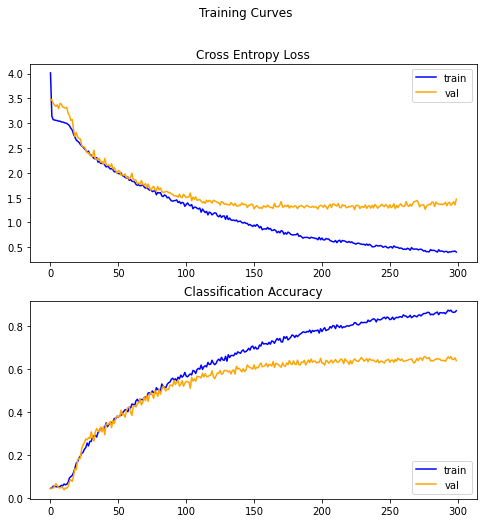


Test set evaluation metrics
30/30 [==============================] - 0s 6ms/step - loss: 1.4340 - accuracy: 0.6474
loss: 1.43
accuracy: 0.65
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 

40/40 [==============================] - 1s 25ms/step - loss: 2.2726 - accuracy: 0.3639 - val_loss: 2.1560 - val_accuracy: 0.3936
Epoch 91/300
40/40 [==============================] - 1s 26ms/step - loss: 2.2068 - accuracy: 0.3696 - val_loss: 2.2122 - val_accuracy: 0.3844
Epoch 92/300
40/40 [==============================] - 1s 25ms/step - loss: 2.2178 - accuracy: 0.3774 - val_loss: 2.2121 - val_accuracy: 0.3877
Epoch 93/300
40/40 [==============================] - 1s 27ms/step - loss: 2.1708 - accuracy: 0.3858 - val_loss: 2.3409 - val_accuracy: 0.3570
Epoch 94/300
40/40 [==============================] - 1s 26ms/step - loss: 2.1686 - accuracy: 0.3823 - val_loss: 2.1562 - val_accuracy: 0.3881
Epoch 95/300
40/40 [==============================] - 1s 26ms/step - loss: 2.1115 - accuracy: 0.3865 - val_loss: 2.1949 - val_accuracy: 0.3863
Epoch 96/300
40/40 [==============================] - 1s 27ms/step - loss: 2.1980 - accuracy: 0.3764 - val_loss: 2.1915 - val_accuracy: 0.3846
Epoch 97/300

40/40 [==============================] - 1s 26ms/step - loss: 1.6960 - accuracy: 0.5068 - val_loss: 1.8464 - val_accuracy: 0.4799
Epoch 148/300
40/40 [==============================] - 1s 25ms/step - loss: 1.6789 - accuracy: 0.4972 - val_loss: 1.8172 - val_accuracy: 0.4869
Epoch 149/300
40/40 [==============================] - 1s 27ms/step - loss: 1.7359 - accuracy: 0.4948 - val_loss: 1.7903 - val_accuracy: 0.4945
Epoch 150/300
40/40 [==============================] - 1s 26ms/step - loss: 1.8012 - accuracy: 0.4807 - val_loss: 1.7951 - val_accuracy: 0.4896
Epoch 151/300
40/40 [==============================] - 1s 28ms/step - loss: 1.7140 - accuracy: 0.5057 - val_loss: 1.7173 - val_accuracy: 0.5188
Epoch 152/300
40/40 [==============================] - 1s 27ms/step - loss: 1.7062 - accuracy: 0.4961 - val_loss: 1.7845 - val_accuracy: 0.4949
Epoch 153/300
40/40 [==============================] - 1s 25ms/step - loss: 1.6915 - accuracy: 0.5048 - val_loss: 1.7345 - val_accuracy: 0.5006
Epoch 

Epoch 204/300
40/40 [==============================] - 1s 27ms/step - loss: 1.4012 - accuracy: 0.5957 - val_loss: 1.5115 - val_accuracy: 0.5711
Epoch 205/300
40/40 [==============================] - 1s 26ms/step - loss: 1.4434 - accuracy: 0.5713 - val_loss: 1.5269 - val_accuracy: 0.5551
Epoch 206/300
40/40 [==============================] - 1s 28ms/step - loss: 1.4146 - accuracy: 0.5712 - val_loss: 1.5973 - val_accuracy: 0.5494
Epoch 207/300
40/40 [==============================] - 1s 27ms/step - loss: 1.4258 - accuracy: 0.5606 - val_loss: 1.5404 - val_accuracy: 0.5609
Epoch 208/300
40/40 [==============================] - 1s 25ms/step - loss: 1.3506 - accuracy: 0.6046 - val_loss: 1.5522 - val_accuracy: 0.5521
Epoch 209/300
40/40 [==============================] - 1s 25ms/step - loss: 1.3629 - accuracy: 0.5986 - val_loss: 1.5482 - val_accuracy: 0.5627
Epoch 210/300
40/40 [==============================] - 1s 26ms/step - loss: 1.3777 - accuracy: 0.5840 - val_loss: 1.6191 - val_accuracy:

Epoch 261/300
40/40 [==============================] - 1s 26ms/step - loss: 1.1554 - accuracy: 0.6569 - val_loss: 1.4474 - val_accuracy: 0.5953
Epoch 262/300
40/40 [==============================] - 1s 27ms/step - loss: 1.1731 - accuracy: 0.6365 - val_loss: 1.4626 - val_accuracy: 0.5879
Epoch 263/300
40/40 [==============================] - 1s 27ms/step - loss: 1.2140 - accuracy: 0.6344 - val_loss: 1.4237 - val_accuracy: 0.5869
Epoch 264/300
40/40 [==============================] - 1s 25ms/step - loss: 1.1383 - accuracy: 0.6503 - val_loss: 1.4779 - val_accuracy: 0.5727
Epoch 265/300
40/40 [==============================] - 1s 28ms/step - loss: 1.2009 - accuracy: 0.6265 - val_loss: 1.4521 - val_accuracy: 0.5943
Epoch 266/300
40/40 [==============================] - 1s 27ms/step - loss: 1.2165 - accuracy: 0.6230 - val_loss: 1.4755 - val_accuracy: 0.5832
Epoch 267/300
40/40 [==============================] - 1s 28ms/step - loss: 1.1421 - accuracy: 0.6593 - val_loss: 1.4985 - val_accuracy:

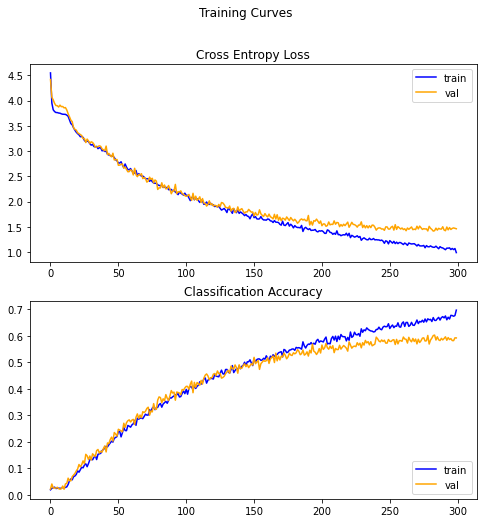


Test set evaluation metrics
30/30 [==============================] - 0s 6ms/step - loss: 1.3641 - accuracy: 0.6151
loss: 1.36
accuracy: 0.62
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 

40/40 [==============================] - 1s 28ms/step - loss: 2.8642 - accuracy: 0.2382 - val_loss: 2.7952 - val_accuracy: 0.2641
Epoch 91/300
40/40 [==============================] - 1s 28ms/step - loss: 2.7983 - accuracy: 0.2478 - val_loss: 2.7190 - val_accuracy: 0.2814
Epoch 92/300
40/40 [==============================] - 1s 27ms/step - loss: 2.7859 - accuracy: 0.2572 - val_loss: 2.7391 - val_accuracy: 0.2777
Epoch 93/300
40/40 [==============================] - 1s 32ms/step - loss: 2.8304 - accuracy: 0.2398 - val_loss: 2.7269 - val_accuracy: 0.2779
Epoch 94/300
40/40 [==============================] - 1s 27ms/step - loss: 2.7580 - accuracy: 0.2664 - val_loss: 2.7432 - val_accuracy: 0.2773
Epoch 95/300
40/40 [==============================] - 1s 29ms/step - loss: 2.7512 - accuracy: 0.2638 - val_loss: 2.6566 - val_accuracy: 0.2920
Epoch 96/300
40/40 [==============================] - 1s 26ms/step - loss: 2.7333 - accuracy: 0.2660 - val_loss: 2.7117 - val_accuracy: 0.2838
Epoch 97/300

40/40 [==============================] - 1s 27ms/step - loss: 2.2887 - accuracy: 0.3658 - val_loss: 2.3090 - val_accuracy: 0.3756
Epoch 148/300
40/40 [==============================] - 1s 28ms/step - loss: 2.2839 - accuracy: 0.3736 - val_loss: 2.3102 - val_accuracy: 0.3834
Epoch 149/300
40/40 [==============================] - 1s 28ms/step - loss: 2.2597 - accuracy: 0.3831 - val_loss: 2.2352 - val_accuracy: 0.3967
Epoch 150/300
40/40 [==============================] - 1s 31ms/step - loss: 2.2713 - accuracy: 0.3668 - val_loss: 2.2262 - val_accuracy: 0.3953
Epoch 151/300
40/40 [==============================] - 1s 29ms/step - loss: 2.2516 - accuracy: 0.3896 - val_loss: 2.1990 - val_accuracy: 0.3951
Epoch 152/300
40/40 [==============================] - 1s 27ms/step - loss: 2.2704 - accuracy: 0.3704 - val_loss: 2.2305 - val_accuracy: 0.3938
Epoch 153/300
40/40 [==============================] - 1s 26ms/step - loss: 2.2198 - accuracy: 0.3946 - val_loss: 2.2579 - val_accuracy: 0.3859
Epoch 

Epoch 204/300
40/40 [==============================] - 1s 30ms/step - loss: 1.9136 - accuracy: 0.4540 - val_loss: 1.9336 - val_accuracy: 0.4646
Epoch 205/300
40/40 [==============================] - 1s 29ms/step - loss: 1.9694 - accuracy: 0.4398 - val_loss: 1.9662 - val_accuracy: 0.4605
Epoch 206/300
40/40 [==============================] - 1s 28ms/step - loss: 1.9238 - accuracy: 0.4574 - val_loss: 2.0529 - val_accuracy: 0.4385
Epoch 207/300
40/40 [==============================] - 1s 26ms/step - loss: 1.9825 - accuracy: 0.4453 - val_loss: 1.9828 - val_accuracy: 0.4568
Epoch 208/300
40/40 [==============================] - 1s 27ms/step - loss: 1.8999 - accuracy: 0.4636 - val_loss: 2.0131 - val_accuracy: 0.4422
Epoch 209/300
40/40 [==============================] - 1s 26ms/step - loss: 1.9578 - accuracy: 0.4594 - val_loss: 1.9263 - val_accuracy: 0.4668
Epoch 210/300
40/40 [==============================] - 1s 28ms/step - loss: 1.8573 - accuracy: 0.4656 - val_loss: 1.9698 - val_accuracy:

Epoch 261/300
40/40 [==============================] - 1s 29ms/step - loss: 1.6356 - accuracy: 0.5307 - val_loss: 1.9265 - val_accuracy: 0.4633
Epoch 262/300
40/40 [==============================] - 1s 29ms/step - loss: 1.7139 - accuracy: 0.5204 - val_loss: 1.8457 - val_accuracy: 0.4920
Epoch 263/300
40/40 [==============================] - 1s 26ms/step - loss: 1.7383 - accuracy: 0.5074 - val_loss: 1.8885 - val_accuracy: 0.4768
Epoch 264/300
40/40 [==============================] - 1s 26ms/step - loss: 1.8033 - accuracy: 0.4848 - val_loss: 1.8472 - val_accuracy: 0.4869
Epoch 265/300
40/40 [==============================] - 1s 26ms/step - loss: 1.6801 - accuracy: 0.5133 - val_loss: 1.8437 - val_accuracy: 0.4895
Epoch 266/300
40/40 [==============================] - 1s 27ms/step - loss: 1.6926 - accuracy: 0.5185 - val_loss: 1.8416 - val_accuracy: 0.4957
Epoch 267/300
40/40 [==============================] - 1s 27ms/step - loss: 1.6935 - accuracy: 0.5161 - val_loss: 1.8152 - val_accuracy:

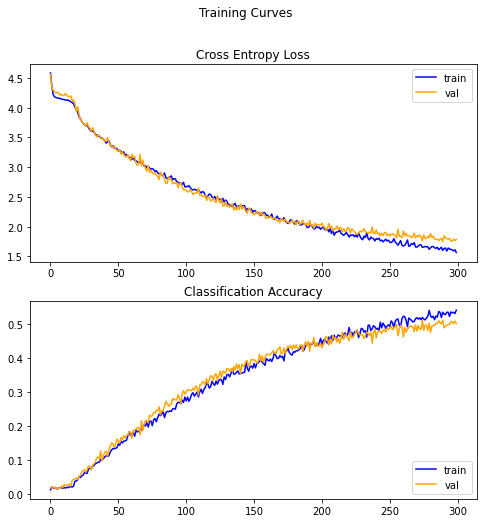


Test set evaluation metrics
30/30 [==============================] - 0s 6ms/step - loss: 1.6866 - accuracy: 0.5352
loss: 1.69
accuracy: 0.54
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 

40/40 [==============================] - 1s 29ms/step - loss: 3.2391 - accuracy: 0.1809 - val_loss: 3.2094 - val_accuracy: 0.2062
Epoch 91/300
40/40 [==============================] - 1s 32ms/step - loss: 3.3259 - accuracy: 0.1815 - val_loss: 3.2213 - val_accuracy: 0.2055
Epoch 92/300
40/40 [==============================] - 1s 29ms/step - loss: 3.2773 - accuracy: 0.1814 - val_loss: 3.1908 - val_accuracy: 0.2123
Epoch 93/300
40/40 [==============================] - 1s 32ms/step - loss: 3.2243 - accuracy: 0.1939 - val_loss: 3.1930 - val_accuracy: 0.2039
Epoch 94/300
40/40 [==============================] - 1s 31ms/step - loss: 3.2243 - accuracy: 0.1889 - val_loss: 3.1479 - val_accuracy: 0.2105
Epoch 95/300
40/40 [==============================] - 1s 31ms/step - loss: 3.2124 - accuracy: 0.2018 - val_loss: 3.1859 - val_accuracy: 0.2109
Epoch 96/300
40/40 [==============================] - 1s 29ms/step - loss: 3.2244 - accuracy: 0.1897 - val_loss: 3.1300 - val_accuracy: 0.2164
Epoch 97/300

40/40 [==============================] - 1s 31ms/step - loss: 2.7657 - accuracy: 0.2838 - val_loss: 2.6725 - val_accuracy: 0.3184
Epoch 148/300
40/40 [==============================] - 1s 28ms/step - loss: 2.7975 - accuracy: 0.2787 - val_loss: 2.6895 - val_accuracy: 0.3145
Epoch 149/300
40/40 [==============================] - 1s 31ms/step - loss: 2.7598 - accuracy: 0.2862 - val_loss: 2.6908 - val_accuracy: 0.3129
Epoch 150/300
40/40 [==============================] - 1s 31ms/step - loss: 2.8159 - accuracy: 0.2734 - val_loss: 2.7372 - val_accuracy: 0.2963
Epoch 151/300
40/40 [==============================] - 1s 33ms/step - loss: 2.8022 - accuracy: 0.2811 - val_loss: 2.7214 - val_accuracy: 0.3018
Epoch 152/300
40/40 [==============================] - 1s 32ms/step - loss: 2.7994 - accuracy: 0.2850 - val_loss: 2.6634 - val_accuracy: 0.3172
Epoch 153/300
40/40 [==============================] - 1s 30ms/step - loss: 2.7407 - accuracy: 0.2959 - val_loss: 2.7033 - val_accuracy: 0.3088
Epoch 

Epoch 204/300
40/40 [==============================] - 1s 29ms/step - loss: 2.4352 - accuracy: 0.3549 - val_loss: 2.3474 - val_accuracy: 0.3850
Epoch 205/300
40/40 [==============================] - 1s 31ms/step - loss: 2.4676 - accuracy: 0.3611 - val_loss: 2.3231 - val_accuracy: 0.3961
Epoch 206/300
40/40 [==============================] - 2s 41ms/step - loss: 2.3908 - accuracy: 0.3674 - val_loss: 2.3033 - val_accuracy: 0.3965
Epoch 207/300
40/40 [==============================] - 1s 30ms/step - loss: 2.4107 - accuracy: 0.3567 - val_loss: 2.3856 - val_accuracy: 0.3848
Epoch 208/300
40/40 [==============================] - 1s 28ms/step - loss: 2.3628 - accuracy: 0.3739 - val_loss: 2.3322 - val_accuracy: 0.3939
Epoch 209/300
40/40 [==============================] - 1s 28ms/step - loss: 2.3596 - accuracy: 0.3632 - val_loss: 2.3482 - val_accuracy: 0.3875
Epoch 210/300
40/40 [==============================] - 1s 28ms/step - loss: 2.4712 - accuracy: 0.3556 - val_loss: 2.3570 - val_accuracy:

Epoch 261/300
40/40 [==============================] - 1s 32ms/step - loss: 2.1769 - accuracy: 0.4066 - val_loss: 2.1630 - val_accuracy: 0.4281
Epoch 262/300
40/40 [==============================] - 1s 34ms/step - loss: 2.1233 - accuracy: 0.4242 - val_loss: 2.1135 - val_accuracy: 0.4357
Epoch 263/300
40/40 [==============================] - 1s 32ms/step - loss: 2.1498 - accuracy: 0.4191 - val_loss: 2.1090 - val_accuracy: 0.4416
Epoch 264/300
40/40 [==============================] - 1s 28ms/step - loss: 2.2365 - accuracy: 0.3912 - val_loss: 2.1593 - val_accuracy: 0.4287
Epoch 265/300
40/40 [==============================] - 1s 29ms/step - loss: 2.1464 - accuracy: 0.4235 - val_loss: 2.1235 - val_accuracy: 0.4293
Epoch 266/300
40/40 [==============================] - 1s 28ms/step - loss: 2.1473 - accuracy: 0.4190 - val_loss: 2.0795 - val_accuracy: 0.4447
Epoch 267/300
40/40 [==============================] - 1s 31ms/step - loss: 2.0945 - accuracy: 0.4333 - val_loss: 2.1003 - val_accuracy:

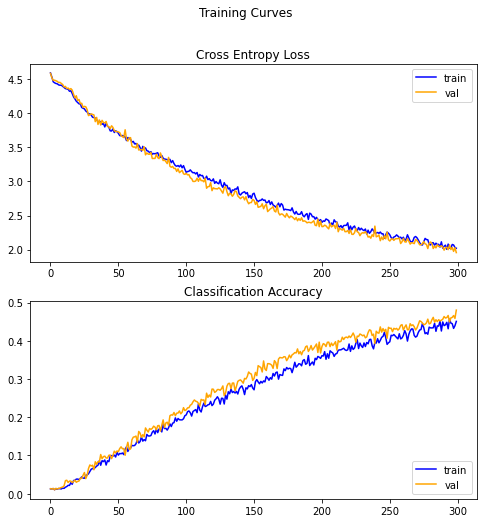


Test set evaluation metrics
30/30 [==============================] - 1s 6ms/step - loss: 1.9328 - accuracy: 0.4792
loss: 1.93
accuracy: 0.48


In [4]:
for nc in range(20,100,20):
    cifar100_classes_url = select_classes_number(nc)
    #@title
    my_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
    CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt',
                                       sep=',', header=None).astype(str).values.tolist()[0]

    our_index = my_classes.iloc[team_seed,:].values.tolist()
    our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
    train_index = get_ds_index(y_train_all, our_index)
    test_index = get_ds_index(y_test_all, our_index)

    x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
    y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
    x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
    y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

    data_size, img_rows, img_cols, img_channels = x_train_ds.shape

    # set validation set percentage (wrt the training set size)
    validation_percentage = 0.15
    val_size = round(validation_percentage * data_size)

    # Reserve val_size samples for validation and normalize all values
    x_val = x_train_ds[-val_size:]/255
    y_val = y_train_ds[-val_size:]
    x_train = x_train_ds[:-val_size]/255
    y_train = y_train_ds[:-val_size]
    x_test = x_test_ds/255
    y_test = y_test_ds

    train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
    validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
    test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object
    
    SCRATCH_MODEL = init_scratch_model(summary = True)
    SCRATCH_MODEL_history = train_model(train_ds, validation_ds, SCRATCH_MODEL, 300, 40, 40)
    model_report(SCRATCH_MODEL, test_ds, SCRATCH_MODEL_history, 30)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

40/40 [==============================] - 1s 21ms/step - loss: 3.9650 - accuracy: 0.0385 - val_loss: 3.9086 - val_accuracy: 0.0820
Epoch 92/300
40/40 [==============================] - 1s 18ms/step - loss: 3.9106 - accuracy: 0.0621 - val_loss: 3.9228 - val_accuracy: 0.0609
Epoch 93/300
40/40 [==============================] - 1s 18ms/step - loss: 3.8543 - accuracy: 0.0701 - val_loss: 3.9421 - val_accuracy: 0.0555
Epoch 94/300
40/40 [==============================] - 1s 18ms/step - loss: 3.9264 - accuracy: 0.0509 - val_loss: 4.0283 - val_accuracy: 0.0500
Epoch 95/300
40/40 [==============================] - 1s 22ms/step - loss: 3.8865 - accuracy: 0.0691 - val_loss: 3.8687 - val_accuracy: 0.0695
Epoch 96/300
40/40 [==============================] - 1s 18ms/step - loss: 3.8370 - accuracy: 0.0739 - val_loss: 3.8683 - val_accuracy: 0.0641
Epoch 97/300
40/40 [==============================] - 1s 18ms/step - loss: 3.8857 - accuracy: 0.0621 - val_loss: 3.8599 - val_accuracy: 0.0695
Epoch 98/300

40/40 [==============================] - 1s 18ms/step - loss: 3.5257 - accuracy: 0.1338 - val_loss: 3.6468 - val_accuracy: 0.1000
Epoch 149/300
40/40 [==============================] - 1s 18ms/step - loss: 3.6336 - accuracy: 0.1034 - val_loss: 3.4645 - val_accuracy: 0.1664
Epoch 150/300
40/40 [==============================] - 1s 19ms/step - loss: 3.5154 - accuracy: 0.1194 - val_loss: 3.4828 - val_accuracy: 0.1391
Epoch 151/300
40/40 [==============================] - 1s 22ms/step - loss: 3.5880 - accuracy: 0.1248 - val_loss: 3.5261 - val_accuracy: 0.1406
Epoch 152/300
40/40 [==============================] - 1s 19ms/step - loss: 3.5045 - accuracy: 0.1287 - val_loss: 3.4275 - val_accuracy: 0.1445
Epoch 153/300
40/40 [==============================] - 1s 18ms/step - loss: 3.5492 - accuracy: 0.1366 - val_loss: 3.4209 - val_accuracy: 0.1406
Epoch 154/300
40/40 [==============================] - 1s 19ms/step - loss: 3.4682 - accuracy: 0.1517 - val_loss: 3.4311 - val_accuracy: 0.1508
Epoch 

Epoch 205/300
40/40 [==============================] - 1s 19ms/step - loss: 3.2873 - accuracy: 0.1842 - val_loss: 3.2772 - val_accuracy: 0.1836
Epoch 206/300
40/40 [==============================] - 1s 22ms/step - loss: 3.3104 - accuracy: 0.1815 - val_loss: 3.1853 - val_accuracy: 0.1914
Epoch 207/300
40/40 [==============================] - 1s 21ms/step - loss: 3.2888 - accuracy: 0.1922 - val_loss: 3.2565 - val_accuracy: 0.1883
Epoch 208/300
40/40 [==============================] - 1s 19ms/step - loss: 3.2171 - accuracy: 0.1934 - val_loss: 3.3262 - val_accuracy: 0.1891
Epoch 209/300
40/40 [==============================] - 1s 18ms/step - loss: 3.2765 - accuracy: 0.1731 - val_loss: 3.1645 - val_accuracy: 0.2039
Epoch 210/300
40/40 [==============================] - 1s 18ms/step - loss: 3.2981 - accuracy: 0.1991 - val_loss: 3.1250 - val_accuracy: 0.2141
Epoch 211/300
40/40 [==============================] - 1s 21ms/step - loss: 3.2463 - accuracy: 0.1993 - val_loss: 3.2496 - val_accuracy:

Epoch 262/300
40/40 [==============================] - 1s 18ms/step - loss: 3.0798 - accuracy: 0.2161 - val_loss: 2.9723 - val_accuracy: 0.2477
Epoch 263/300
40/40 [==============================] - 1s 21ms/step - loss: 3.0700 - accuracy: 0.2110 - val_loss: 3.0293 - val_accuracy: 0.2367
Epoch 264/300
40/40 [==============================] - 1s 20ms/step - loss: 3.1339 - accuracy: 0.2312 - val_loss: 2.9880 - val_accuracy: 0.2289
Epoch 265/300
40/40 [==============================] - 1s 18ms/step - loss: 3.1547 - accuracy: 0.2175 - val_loss: 2.9347 - val_accuracy: 0.2508
Epoch 266/300
40/40 [==============================] - 1s 18ms/step - loss: 2.9854 - accuracy: 0.2238 - val_loss: 3.0062 - val_accuracy: 0.2430
Epoch 267/300
40/40 [==============================] - 1s 21ms/step - loss: 3.0275 - accuracy: 0.2126 - val_loss: 2.8729 - val_accuracy: 0.2523
Epoch 268/300
40/40 [==============================] - 1s 18ms/step - loss: 3.0481 - accuracy: 0.2026 - val_loss: 2.9189 - val_accuracy:

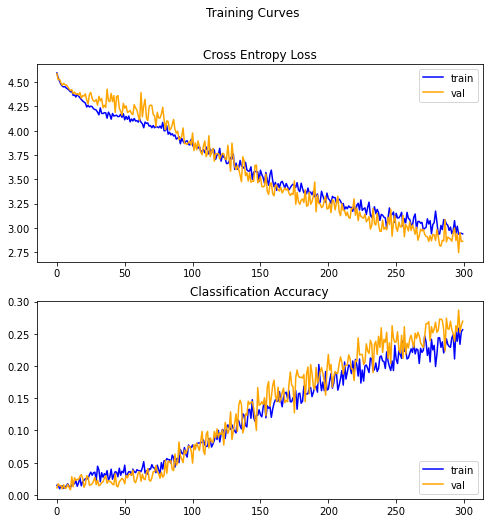


Test set evaluation metrics
30/30 [==============================] - 1s 4ms/step - loss: 2.7810 - accuracy: 0.2823
loss: 2.78
accuracy: 0.28
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 

40/40 [==============================] - 1s 23ms/step - loss: 3.7054 - accuracy: 0.0966 - val_loss: 3.6336 - val_accuracy: 0.1195
Epoch 91/300
40/40 [==============================] - 1s 23ms/step - loss: 3.6603 - accuracy: 0.1036 - val_loss: 3.6659 - val_accuracy: 0.1219
Epoch 92/300
40/40 [==============================] - 1s 27ms/step - loss: 3.6272 - accuracy: 0.1131 - val_loss: 3.6208 - val_accuracy: 0.1250
Epoch 93/300
40/40 [==============================] - 1s 23ms/step - loss: 3.6344 - accuracy: 0.1147 - val_loss: 3.6043 - val_accuracy: 0.1301
Epoch 94/300
40/40 [==============================] - 1s 22ms/step - loss: 3.6189 - accuracy: 0.0989 - val_loss: 3.5665 - val_accuracy: 0.1375
Epoch 95/300
40/40 [==============================] - 1s 26ms/step - loss: 3.5830 - accuracy: 0.1373 - val_loss: 3.5371 - val_accuracy: 0.1363
Epoch 96/300
40/40 [==============================] - 1s 23ms/step - loss: 3.5619 - accuracy: 0.1186 - val_loss: 3.5371 - val_accuracy: 0.1445
Epoch 97/300

40/40 [==============================] - 1s 22ms/step - loss: 3.2024 - accuracy: 0.1941 - val_loss: 3.1483 - val_accuracy: 0.2117
Epoch 148/300
40/40 [==============================] - 1s 23ms/step - loss: 3.1499 - accuracy: 0.2038 - val_loss: 3.0535 - val_accuracy: 0.2316
Epoch 149/300
40/40 [==============================] - 1s 28ms/step - loss: 3.0939 - accuracy: 0.2106 - val_loss: 3.0011 - val_accuracy: 0.2352
Epoch 150/300
40/40 [==============================] - 1s 23ms/step - loss: 3.1275 - accuracy: 0.2119 - val_loss: 3.0330 - val_accuracy: 0.2238
Epoch 151/300
40/40 [==============================] - 1s 22ms/step - loss: 3.0473 - accuracy: 0.2178 - val_loss: 3.0123 - val_accuracy: 0.2293
Epoch 152/300
40/40 [==============================] - 1s 22ms/step - loss: 3.0595 - accuracy: 0.2267 - val_loss: 3.0911 - val_accuracy: 0.2238
Epoch 153/300
40/40 [==============================] - 1s 24ms/step - loss: 3.1708 - accuracy: 0.2004 - val_loss: 3.1012 - val_accuracy: 0.2133
Epoch 

Epoch 204/300
40/40 [==============================] - 1s 24ms/step - loss: 2.8075 - accuracy: 0.2797 - val_loss: 2.7413 - val_accuracy: 0.3000
Epoch 205/300
40/40 [==============================] - 1s 22ms/step - loss: 2.7738 - accuracy: 0.2865 - val_loss: 2.7925 - val_accuracy: 0.2879
Epoch 206/300
40/40 [==============================] - 1s 22ms/step - loss: 2.7506 - accuracy: 0.2935 - val_loss: 2.6814 - val_accuracy: 0.2926
Epoch 207/300
40/40 [==============================] - 1s 23ms/step - loss: 2.8048 - accuracy: 0.2558 - val_loss: 2.7165 - val_accuracy: 0.2996
Epoch 208/300
40/40 [==============================] - 1s 22ms/step - loss: 2.7557 - accuracy: 0.2844 - val_loss: 2.8390 - val_accuracy: 0.2840
Epoch 209/300
40/40 [==============================] - 1s 23ms/step - loss: 2.8009 - accuracy: 0.2710 - val_loss: 2.6269 - val_accuracy: 0.3219
Epoch 210/300
40/40 [==============================] - 1s 22ms/step - loss: 2.7973 - accuracy: 0.2750 - val_loss: 2.6387 - val_accuracy:

Epoch 261/300
40/40 [==============================] - 1s 25ms/step - loss: 2.5237 - accuracy: 0.3227 - val_loss: 2.5030 - val_accuracy: 0.3434
Epoch 262/300
40/40 [==============================] - 1s 23ms/step - loss: 2.6033 - accuracy: 0.3222 - val_loss: 2.5894 - val_accuracy: 0.3230
Epoch 263/300
40/40 [==============================] - 1s 28ms/step - loss: 2.4933 - accuracy: 0.3505 - val_loss: 2.4910 - val_accuracy: 0.3395
Epoch 264/300
40/40 [==============================] - 1s 25ms/step - loss: 2.5930 - accuracy: 0.3197 - val_loss: 2.4280 - val_accuracy: 0.3734
Epoch 265/300
40/40 [==============================] - 1s 22ms/step - loss: 2.5629 - accuracy: 0.3340 - val_loss: 2.4129 - val_accuracy: 0.3707
Epoch 266/300
40/40 [==============================] - 1s 22ms/step - loss: 2.5483 - accuracy: 0.3313 - val_loss: 2.4259 - val_accuracy: 0.3566
Epoch 267/300
40/40 [==============================] - 1s 22ms/step - loss: 2.4657 - accuracy: 0.3380 - val_loss: 2.4069 - val_accuracy:

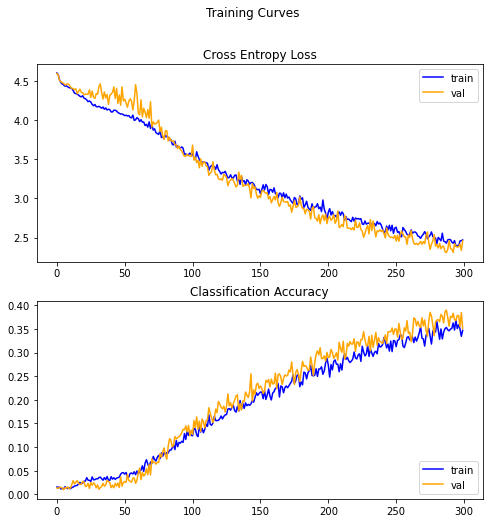


Test set evaluation metrics
30/30 [==============================] - 0s 4ms/step - loss: 2.4559 - accuracy: 0.3458
loss: 2.46
accuracy: 0.35


In [8]:
for BATCH_SIZE in [32, 64]:
    cifar100_classes_url = select_classes_number(80)
    #@title
    my_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
    CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt',
                                       sep=',', header=None).astype(str).values.tolist()[0]

    our_index = my_classes.iloc[team_seed,:].values.tolist()
    our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
    train_index = get_ds_index(y_train_all, our_index)
    test_index = get_ds_index(y_test_all, our_index)

    x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
    y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
    x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
    y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

    data_size, img_rows, img_cols, img_channels = x_train_ds.shape

    # set validation set percentage (wrt the training set size)
    validation_percentage = 0.15
    val_size = round(validation_percentage * data_size)

    # Reserve val_size samples for validation and normalize all values
    x_val = x_train_ds[-val_size:]/255
    y_val = y_train_ds[-val_size:]
    x_train = x_train_ds[:-val_size]/255
    y_train = y_train_ds[:-val_size]
    x_test = x_test_ds/255
    y_test = y_test_ds

    train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
    validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
    test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object
    
    SCRATCH_MODEL = init_scratch_model(summary = True)
    SCRATCH_MODEL_history = train_model(train_ds, validation_ds, SCRATCH_MODEL, 300, 40, 40)
    model_report(SCRATCH_MODEL, test_ds, SCRATCH_MODEL_history, 30)